In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import EfficientNetB6, ResNet50, VGG16, Xception
from keras.utils import plot_model

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [29]:
base_dir = '../data/telemoji/pre'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

def make_blk(colar_pixel):
    test = np.mean(colar_pixel, axis=2, keepdims=True)
    test_array = np.concatenate([test,test,test], axis=2)
    return test_array

train_datagen = ImageDataGenerator(
    rescale=1/255,    
#     rotation_range=40,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
    validation_split=0.2,
    preprocessing_function = make_blk
)

test_datagen = ImageDataGenerator(
    rescale=1/255,
    preprocessing_function = make_blk
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 15986 images belonging to 7 classes.
Found 3992 images belonging to 7 classes.
Found 2074 images belonging to 7 classes.


[[[0.01437909 0.01437909 0.01437909]
  [0.02222222 0.02222222 0.02222222]
  [0.0379085  0.0379085  0.0379085 ]
  ...
  [0.12810458 0.12810458 0.12810458]
  [0.15555558 0.15555558 0.15555558]
  [0.20653597 0.20653597 0.20653597]]

 [[0.01699346 0.01699346 0.01699346]
  [0.02614379 0.02614379 0.02614379]
  [0.04183007 0.04183007 0.04183007]
  ...
  [0.13202615 0.13202615 0.13202615]
  [0.13594772 0.13594772 0.13594772]
  [0.14379086 0.14379086 0.14379086]]

 [[0.0248366  0.0248366  0.0248366 ]
  [0.03660131 0.03660131 0.03660131]
  [0.05228758 0.05228758 0.05228758]
  ...
  [0.15555558 0.15555558 0.15555558]
  [0.13986929 0.13986929 0.13986929]
  [0.11633988 0.11633988 0.11633988]]

 ...

 [[0.09803922 0.09803922 0.09803922]
  [0.14379086 0.14379086 0.14379086]
  [0.16209151 0.16209151 0.16209151]
  ...
  [0.29281047 0.29281047 0.29281047]
  [0.3006536  0.3006536  0.3006536 ]
  [0.30457518 0.30457518 0.30457518]]

 [[0.10980393 0.10980393 0.10980393]
  [0.12026145 0.12026145 0.12026145]


IndexError: list index out of range

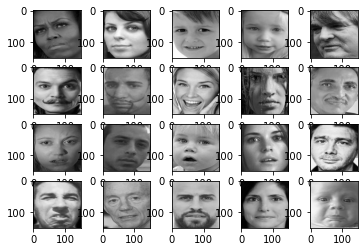

In [32]:
fig = plt.figure()
fig_arr = list()
for i in range(20):
    fig_arr.append(fig.add_subplot(4,5,i+1))

for data_batch, lable_batch in train_generator:
    for idx, img_data in enumerate(data_batch):
        print(img_data)
        fig_arr[idx].imshow(img_data, cmap='gray')
    break

plt.tight_layout()
plt.show()

# 전이 학습

In [ ]:
# pretrained network
model_base = EfficientNetB6(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

In [ ]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, steps_per_epoch=159, epochs=20,
                    validation_data=validation_generator, validation_steps=39)

In [ ]:
result = model.evaluate(test_generator)
print(result)

In [ ]:
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:
        layer.trainable=True
    else:
        layer.trainable=False

# 미세조정이므로 learning_rate를 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, steps_per_epoch=159, epochs=20,
                    validation_data=validation_generator, validation_steps=39)

In [ ]:
result = model.evaluate(test_generator)
print(result)

# 새로운 전이학습 모델

In [6]:
# pretrained network
model_base = Xception(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

# model.add(AveragePooling2D())

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

83689472/83683744 [==============================] - 4s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 358407    
Total params: 21,219,887
Trainable params: 358,407
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
history = model.fit(train_generator, steps_per_epoch=159, epochs=20,
                    validation_data=validation_generator, validation_steps=39)

In [ ]:
result = model.evaluate(test_generator)
print(result)

In [ ]:
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:
        layer.trainable=True
    else:
        layer.trainable=False

# 미세조정이므로 learning_rate를 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, steps_per_epoch=159, epochs=20,
                    validation_data=validation_generator, validation_steps=39)

In [ ]:
result = model.evaluate(test_generator)
print(result)

In [ ]:
## 다른 모델

model = Sequential()
model.add(Conv2D(64, (1, 1), padding='same', activation='relu', 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (5, 5),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2),padding="same"))
model.add(Dropout(0.25))

model.add(Conv2D(256, (5, 5),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2),padding="same"))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
## 다른 모델 논문 참고 모델
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', 
                 input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0

In [7]:
plot_model(model, to_file='../data/models/논문1_1.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
history = model.fit(train_generator, steps_per_epoch=159, epochs=30,
                    validation_data=validation_generator, validation_steps=39)

In [ ]:
result = model.evaluate(test_generator)
print(result)